# Explorative analysis for extrapolation of cic savings data across multiple years

- Determine average temperature on certain days / months vs. average temperatures that we have measured.
- Extrapolate expected temperatures based on this comparison
- Determine heat demand based on these temperatures
- with COP / temperature and %-by-hp / temperature determine heat by hp extrapolated and energy consumption extrapolated


Inputs:  
etmgeg_260.txt: text file containing KNMI weather measurements in the Bilt 1901-aug2023

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [57]:
# load temperature data from file
with open('./data/etmgeg_260.txt','r') as f:
    content = f.readlines()
    header = content[51].split(',')
    header = [h.strip() for h in header]
    data = [line.split(',') for line in content[53:-1]]

    df = pd.DataFrame(columns=header, data=data)

In [83]:
# plot tg over time
df['date'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')
df['TG'] = df['TG'].astype(float)/10

# plot average temperature per day for data of the last 10 years (up to 2022)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['month-day'] = df['date'].dt.strftime('%m-%d')

# create new dataframe with average temperature per day (for last 10 years)
df_year=pd.DataFrame()
df_year['month-day'] = df[df['year']==2022]['month-day']
# set month-day as index of frame
df_year = df_year.set_index('month-day')
for year in range(2012, 2023):
    df_year[f'TG-{year}'] = df[(df['year']==year) & (df['month-day']!='02-29')]['TG'].values

df_year['TG-avg'] = df_year.mean(axis=1)
df_year['TG-min'] = df_year.min(axis=1)
df_year['TG-max'] = df_year.max(axis=1)


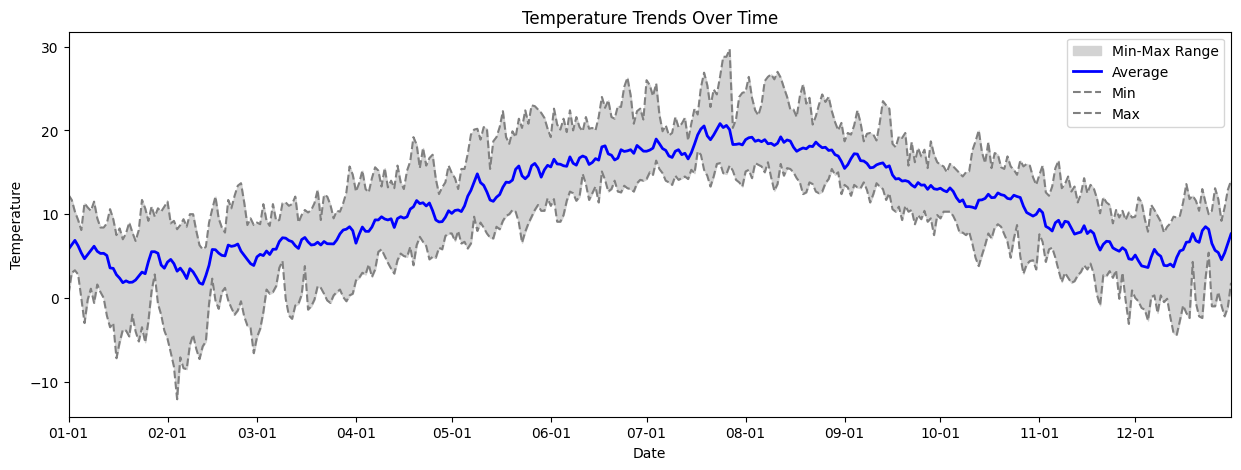

In [93]:
# Plot temperature trend of the last 10 years
df_year['Date'] = pd.to_datetime(df_year.index, format='%m-%d')

# Plotting
plt.figure(figsize=(15, 5))

plt.fill_between(df_year['Date'], df_year['TG-min'], df_year['TG-max'], color='lightgrey', label='Min-Max Range')
plt.plot(df_year['Date'], df_year['TG-avg'], color='blue', linewidth=2, label='Average')
plt.plot(df_year['Date'], df_year['TG-min'], color='grey', linestyle='--', label='Min')
plt.plot(df_year['Date'], df_year['TG-max'], color='grey', linestyle='--', label='Max')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Trends Over Time')
plt.legend()

# Set x-axis limits to the minimum and maximum date values
plt.xlim(df_year['Date'].min(), df_year['Date'].max())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Show the plot
plt.show()

In [ ]:
# Estimate and plot heat demand based on degree days
# assuming that: heat demand will go up linearly with temperature, however it's influenced by a factor which is dependant on the month (weighted degree days)
